<a href="https://colab.research.google.com/github/rgilyard/parallel-edge-detection/blob/main/parallel_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Edge Detection and Parallel Processing

## Import Libraries

In [45]:
import torch
from PIL import Image, ImageOps
import os
import numpy as np

In [46]:
print("Number of available GPUs:", torch.cuda.device_count())

Number of available GPUs: 1


### Check that CUDA is available

In [47]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use index 1 instead of the default index 0
else:
    device = torch.device("cpu")

print("using", device, "device")
print(device)

using cuda device
cuda


### Print what hardware is beign used

In [48]:
# GPU information
!nvidia-smi
print()
# CPU information
!lscpu
print()
# Memory information
!free -h

Tue May  9 21:21:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    34W /  70W |   1459MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Set image folder paths

In [49]:
# For colab
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')
image_folder = '/content/drive/My Drive/COMP 620 Group Project/edge_gpu/images'


# Input and output paths
# image_folder = 'images'
input_folder_path = 'input'
output_folder_path = 'output'

# Dummy path for multiple sequential loading
dummy = 'dummy_class'
single = 'single_images'

# Multiple image paths
multiple_image_paths = ['2_images', '4_images', '8_images',\
                        '16_images', '32_images', '64_images', '128_images',\
                        '256_images', '512_images', '1024_images']
# multiple_image_paths = ['2_images', '4_images', '8_images']

# Single image paths
single_image_paths = ['whistler.png', 'wave.png', 'starry.png', 'persistence.png',\
                      'pipe.png', 'nightwatch.png', 'cardsharps.png', 'paris.png',\
                      'washington.png', 'fragments.png', 'pedlar.png', 'calvary.png']
# single_image_paths = ['whistler.png', 'wave.png', 'starry.png']

# Lists for the algorithms to run, input then output paths
multiple_sequential_paths = []
multiple_parallel_paths = []
single_sequential_paths = []
single_parallel_paths = []

# Make multiple image path lists
for path in multiple_image_paths:
    sequential = (os.path.join(image_folder, input_folder_path, path, dummy, ''), \
                  os.path.join(image_folder, output_folder_path, path, ''))
    multiple_sequential_paths.append(sequential)
    parallel = (os.path.join(image_folder, input_folder_path, path, ''), \
                  os.path.join(image_folder, output_folder_path, path, ''))
    multiple_parallel_paths.append(parallel)
                
# Make single image path lists
for path in single_image_paths:
    sequential = (os.path.join(image_folder, input_folder_path, single, path), \
                  os.path.join(image_folder, output_folder_path, single, path))
    single_sequential_paths.append(sequential)
    parallel = (os.path.join(image_folder, input_folder_path, single, path), \
                  os.path.join(image_folder, output_folder_path, single, path))
    single_parallel_paths.append(parallel)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Set parameters

In [50]:
# This prevents pillow from throwing a DecompressionBombError for the largest images
Image.MAX_IMAGE_PIXELS = 10_000_000_000

patch_size = 1024
batch_size = 64 # Number of image in a dataloader batch
num_workers = 2 # Parallelization for dataloading (CPU, not GPU)

### Set constants

In [51]:
# ADD CONSTANTS FOR PARALLEL AND SEQUENTIAL KERNELS, maybe define kernel separately

# Sequential Sobel kernels
sobel_x_kernel_seq = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
sobel_y_kernel_seq = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float32)

# Sobel operator kernels for horizontal and vertical edges (parallel)
sobel_x_kernel_par = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32)
sobel_y_kernel_par = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32)

# Unsqueeze the Sobel kernels to match the shape
# (C_out, C_in, H_kernel, W_kernel)
sobel_x_kernel_expanded = sobel_x_kernel_par.unsqueeze(0).unsqueeze(0).to(device)
sobel_y_kernel_expanded = sobel_y_kernel_par.unsqueeze(0).unsqueeze(0).to(device)

### Additional Functions

In [52]:
import torchvision.transforms.functional as F

# Function to save tensor to image
def save_image_from_tensor(tensor_img, output_path):
    # Convert the tensor back to a PIL image
    pil_img = F.to_pil_image(tensor_img)
    
    # Save the image to the output folder
    pil_img.save(output_path)

## Sequential Edge Detection Algorithms

#### Libraries

In [53]:
import glob
from scipy import ndimage
import gc

### Sequential Single Image Algorithm

In [54]:
# Edge detection for single image
def sequential_single(file_path, output_folder, patch_size=patch_size, overlap=1):
    # Load the image and convert it to grayscale
    img = Image.open(file_path).convert("L")
    width, height = img.size

    mega_pixels = (width * height) / 1000000
    # Convert the patch to a numpy array
    np_image = np.asarray(img, dtype=np.float32)

    # Free memory
    del img
    gc.collect()  

    # Apply Sobel kernels to the patch
    edge_x = ndimage.convolve(np_image, sobel_x_kernel_seq, mode="constant", cval=0)
    edge_y = ndimage.convolve(np_image, sobel_y_kernel_seq, mode="constant", cval=0)

    # Free memory
    del np_image
    gc.collect()  

    # Calculate the magnitude of the gradients
    edge_magnitude = np.sqrt(edge_x ** 2 + edge_y ** 2)

    # Free memory
    del edge_x
    del edge_y
    gc.collect() 

    # Normalize the edge magnitude to the range [0, 255]
    edge_magnitude = edge_magnitude.astype(np.uint8)

    # Create a PIL Image from the numpy array
    output_img = Image.fromarray(edge_magnitude)

    # Free memory
    del edge_magnitude
    gc.collect()

    # Save the edge-detected image to the output folder
    output_img.save(output_folder)
    return mega_pixels

In [55]:
# # Edge detection for single image
# def sequential_single(file_path, output_folder, patch_size=patch_size, overlap=1):
#     # Load the image and convert it to grayscale
#     img = Image.open(file_path).convert("L")
#     width, height = img.size

#     # Create an empty output image
#     output_img = Image.new("L", (width, height))

#     # Calculate the number of patches in both dimensions
#     num_patches_w = math.ceil((width - patch_size) / (patch_size - overlap)) + 1
#     num_patches_h = math.ceil((height - patch_size) / (patch_size - overlap)) + 1

#     for i in range(num_patches_h):
#         for j in range(num_patches_w):
#             # Extract a patch from the large image
#             left = j * (patch_size - overlap)
#             upper = i * (patch_size - overlap)
#             right = min(left + patch_size, width)
#             lower = min(upper + patch_size, height)
#             patch = img.crop((left, upper, right, lower))

#             # Convert the patch to a numpy array
#             patch_array = np.asarray(patch, dtype=np.float32)

#             # Apply Sobel kernels to the patch
#             edge_x = ndimage.convolve(patch_array, sobel_x_kernel_seq, mode="constant", cval=0)
#             edge_y = ndimage.convolve(patch_array, sobel_y_kernel_seq, mode="constant", cval=0)

#             # Calculate the magnitude of the gradients
#             edge_magnitude = np.sqrt(edge_x ** 2 + edge_y ** 2)

#             # Normalize the edge magnitude to the range [0, 255]
#             edge_magnitude = edge_magnitude.astype(np.uint8)

#             # Create a PIL Image from the numpy array
#             edge_patch = Image.fromarray(edge_magnitude)

#             # Paste the edge-detected patch into the output image
#             output_img.paste(edge_patch, (left, upper))
    
#     del img
#     gc.collect()

#     # Save the edge-detected image to the output folder
#     output_img.save(output_folder)

### Sequential Multiple Image Algorithm

In [56]:
# Sequential algorithm for all the images in a folder
def sequential_multiple(input_folder, output_folder):
    # Get the list of image file paths in the input folder
    image_files = glob.glob(os.path.join(input_folder, "*"))

    # Iterate through each image file
    for index, file_path in enumerate(image_files):
        # Load the image and convert it to grayscale
        img = Image.open(file_path).convert("L")

        # Convert the image to a numpy array
        img_array = np.asarray(img, dtype=np.float32)

        # Apply Sobel kernels to the image
        edge_x = ndimage.convolve(img_array, sobel_x_kernel_seq, mode="constant", cval=0)
        edge_y = ndimage.convolve(img_array, sobel_y_kernel_seq, mode="constant", cval=0)

        # Calculate the magnitude of the gradients
        edge_magnitude = np.sqrt(edge_x ** 2 + edge_y ** 2)

        # Normalize the edge magnitude to the range [0, 255]
        edge_magnitude = edge_magnitude.astype(np.uint8)

        # Create a PIL Image from the numpy array
        edge_image = Image.fromarray(edge_magnitude)

        # Save the edge-detected image to the output folder
        img_output_path = os.path.join(output_folder, f'edge_{index}.png')
        edge_image.save(img_output_path)

## Parallel Edge Detection Algorithm

#### Libraries

In [57]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.nn.functional import conv2d
import math
from torchvision.transforms.functional import to_pil_image

### Parallel Single Image Algorithm

In [58]:
def parallel_single(input_image_path, output_image_path, patch_size=patch_size, overlap=2):
    # Load the large image and convert it to grayscale
    large_img = Image.open(input_image_path).convert("L")
    
    width, height = large_img.size
    mega_pixels = (width * height) / 1000000
    # Calculate the number of patches required to cover the image, get the padding size to be added
    pad_width = (math.ceil((width - overlap) / (patch_size - overlap)) - 1) * (patch_size - overlap) + patch_size - width
    pad_height = (math.ceil((height - overlap) / (patch_size - overlap)) - 1) * (patch_size - overlap) + patch_size - height

    # Add padding to the image
    large_img = ImageOps.expand(large_img, (0, 0, pad_width, pad_height), fill=0)
    
    # New width and height
    new_width, new_height = large_img.size

    # Calculate the number of patches along width and height
    num_patches_w = math.ceil((new_width - overlap) / (patch_size - overlap))
    num_patches_h = math.ceil((new_height - overlap) / (patch_size - overlap))

    # Create an empty image to store the edge-detected result
    output_img = Image.new("L", (new_width, new_height))
    
    patches = []

    for i in range(num_patches_h):
        for j in range(num_patches_w):
            # Extract a patch from the large image
            left = j * (patch_size - overlap)
            upper = i * (patch_size - overlap)
            right = min(left + patch_size, new_width)
            lower = min(upper + patch_size, new_height)
            patch = large_img.crop((left, upper, right, lower))
            
            # Append the patch to the patches list
            patches.append(patch)

    del large_img
    gc.collect()
            
    # Split the patches list into smaller sublists (batches)
    patch_batches = [patches[i:i + batch_size] for i in range(0, len(patches), batch_size)]
        
    for batch_idx, patch_batch in enumerate(patch_batches):
        # Convert the patches to tensors and stack them into a single tensor
        patches_tensor = torch.stack([transforms.ToTensor()(patch) for patch in patch_batch]).to(device)
        
        # Convolve the patches with the Sobel kernels
        edge_x = conv2d(patches_tensor, sobel_x_kernel_expanded, padding=1)
        edge_y = conv2d(patches_tensor, sobel_y_kernel_expanded, padding=1)

        # Combine the horizontal and vertical edges using the L2 norm
        edge_detected_patches = torch.sqrt(edge_x ** 2 + edge_y ** 2)

        # Process the edge-detected patches and paste them into the output image
        for i, edge_detected_patch in enumerate(edge_detected_patches):
            # Convert the edge-detected patch back to a PIL image
            edge_detected_patch = to_pil_image(edge_detected_patch.cpu())

            # Crop the patch to remove the top and left two pixels
            edge_detected_patch = edge_detected_patch.crop((2, 2, edge_detected_patch.width, edge_detected_patch.height))
            
            # Calculate the index of the patch in the original patches list
            original_patch_idx = batch_idx * batch_size + i

            # Calculate the position of the patch in the output image
            row_idx = original_patch_idx // num_patches_w
            col_idx = original_patch_idx % num_patches_w
            left = col_idx * (patch_size - overlap)
            upper = row_idx * (patch_size - overlap)

            # Paste the edge-detected patch into the output image
            output_img.paste(edge_detected_patch, (left, upper))
            del edge_detected_patch
        # Send the tensor back to the cpu to save space
        patches_tensor = patches_tensor.cpu()
        edge_x = edge_x.cpu()
        edge_y = edge_y.cpu()
        edge_detected_patches = edge_detected_patches.cpu()
        del patches_tensor
        del edge_x
        del edge_y
        del edge_detected_patches
        torch.cuda.empty_cache()
        gc.collect()

    # Save the edge-detected large image
    output_img.save(output_image_path)
    
    # Garbage collect
    del output_img
    del patch_batches
    gc.collect()
    return mega_pixels

### Parallel Multiple Image Algorithm

In [59]:
# Finds edges for all the images in a folder in parallel
def parallel_multiple(img_folder, output_folder):
    # Define the transformation pipeline (it's not much 
    # a pipline, because I'm only converting to tensors)
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])
    
    # Create an ImageFolder dataset
    dataset = ImageFolder(root=img_folder, transform=transform)
    
    # Create a DataLoader to handle batching
    dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=num_workers)
    
    for batch_idx, (data, _) in enumerate(dataloader):
        # Move the data to the GPU
        data = data.to(device)
        
        # Convolve the image with the Sobel kernels
        edge_x = conv2d(data, sobel_x_kernel_expanded, padding=1)
        edge_y = conv2d(data, sobel_y_kernel_expanded, padding=1)

        # Combine the horizontal and vertical edges using the L2 norm
        edge_detected_batch = torch.sqrt(edge_x ** 2 + edge_y ** 2).squeeze()

        # Save each image
        for index, edge_detected_image in enumerate(edge_detected_batch):
            # Ensure the input tensor has at least 2 dimensions
            edge_detected_image = edge_detected_image.unsqueeze(0)\
                if edge_detected_image.ndimension() == 1 else edge_detected_image
            # Convert the tensor back to a PIL image
            pil_img = F.to_pil_image(edge_detected_image)
            # Save the image to the output folder
            img_output_path = os.path.join(output_folder, f'edge_{index}.png')
            save_image_from_tensor(edge_detected_image.cpu(), img_output_path)
        # Send the data back to the cpu to save space
        data = data.cpu()
        edge_detected_batch = edge_detected_batch.cpu()
        edge_x = edge_x.cpu()
        edge_y = edge_y.cpu()        
        del data
        del edge_detected_batch
        del edge_x
        del edge_y
        torch.cuda.empty_cache()
        gc.collect()

    del dataloader
    del transform
    del dataset
    torch.cuda.empty_cache()
    gc.collect()

## Run Algorithms and Measure for Speed

In [60]:
import timeit

# Function to time functions over all image paths
# and return a list of times
def mult_time_function(function, paths):
    print('timing functions')
    time_list = []
    for path in paths:
        # Record the start time
        start_time = timeit.default_timer()
        # Run the function
        function(path[0], path[1])
        # End timer, calculate time, append time to list
        end_time = timeit.default_timer()
        elapsed_time = end_time - start_time
        time_list.append(elapsed_time)
        print('Seconds: ' + str(elapsed_time))
    print()
    return time_list

In [61]:
# Function to time functions over all image paths
# and return a list of times
def single_time_function(function, paths):
    print('timing functions')
    time_list = []
    for path in paths:
        # Record the start time
        start_time = timeit.default_timer()
        # Run the function
        size = function(path[0], path[1])
        # End timer, calculate time, append time to list
        end_time = timeit.default_timer()
        elapsed_time = end_time - start_time
        time_list.append((size, elapsed_time))
        print('Seconds: ' + str(elapsed_time))
    print()
    return time_list

In [62]:
# List of multiple, sequential times
mult_seq_timings = mult_time_function(sequential_multiple, multiple_sequential_paths)

# First parallel takes always takes a long time, so I run one test one
parallel_multiple(multiple_parallel_paths[0][0], multiple_parallel_paths[0][1])

# List of multiple, parallel times
mult_par_timings = mult_time_function(parallel_multiple, multiple_parallel_paths)

# List of single, sequential times
sing_seq_timings = single_time_function(sequential_single, single_sequential_paths)

# List of single, parallel times
sing_par_timings = single_time_function(parallel_single, single_parallel_paths)

timing functions
Seconds: 1.463435871999991
Seconds: 2.7391334110000116
Seconds: 5.513807445999987
Seconds: 26.753093825000064
Seconds: 55.02777227199999
Seconds: 106.13546947999998
Seconds: 159.17034882899998
Seconds: 316.7991901539999
Seconds: 608.8774801019999
Seconds: 1214.1101193299999

timing functions
Seconds: 1.8614021529997444
Seconds: 3.048260745999869
Seconds: 5.844361418000062
Seconds: 11.01135153999985
Seconds: 21.94937232300026
Seconds: 40.87437238400025
Seconds: 79.00069047499983
Seconds: 153.140739295
Seconds: 302.84671408099985
Seconds: 602.556774052

timing functions
Seconds: 0.32839224500003183
Seconds: 0.32753020400014066
Seconds: 0.35607592399992427
Seconds: 1.3613392379993456
Seconds: 1.36582217600062
Seconds: 1.2903583849993083
Seconds: 1.532818328999383
Seconds: 1.9820573510005488
Seconds: 3.809270963000017
Seconds: 11.659459485999832
Seconds: 37.8801460450004
Seconds: 159.25715729700005

timing functions
Seconds: 0.33012323999992077
Seconds: 0.27283209300003364

In [63]:
print(mult_seq_timings)
print(mult_par_timings)
print(sing_seq_timings)
print(sing_par_timings)

[1.463435871999991, 2.7391334110000116, 5.513807445999987, 26.753093825000064, 55.02777227199999, 106.13546947999998, 159.17034882899998, 316.7991901539999, 608.8774801019999, 1214.1101193299999]
[1.8614021529997444, 3.048260745999869, 5.844361418000062, 11.01135153999985, 21.94937232300026, 40.87437238400025, 79.00069047499983, 153.140739295, 302.84671408099985, 602.556774052]
[(0.000256, 0.32839224500003183), (0.001024, 0.32753020400014066), (0.004096, 0.35607592399992427), (0.016384, 1.3613392379993456), (0.065536, 1.36582217600062), (0.262144, 1.2903583849993083), (1.048576, 1.532818328999383), (4.194304, 1.9820573510005488), (16.777216, 3.809270963000017), (67.108864, 11.659459485999832), (268.435456, 37.8801460450004), (1073.741824, 159.25715729700005)]
[(0.000256, 0.33012323999992077), (0.001024, 0.27283209300003364), (0.004096, 0.261250198000198), (0.016384, 0.2685950639997827), (0.065536, 0.2616176910005379), (0.262144, 0.32070165499953873), (1.048576, 0.8411774439991859), (4.

### Print Figures

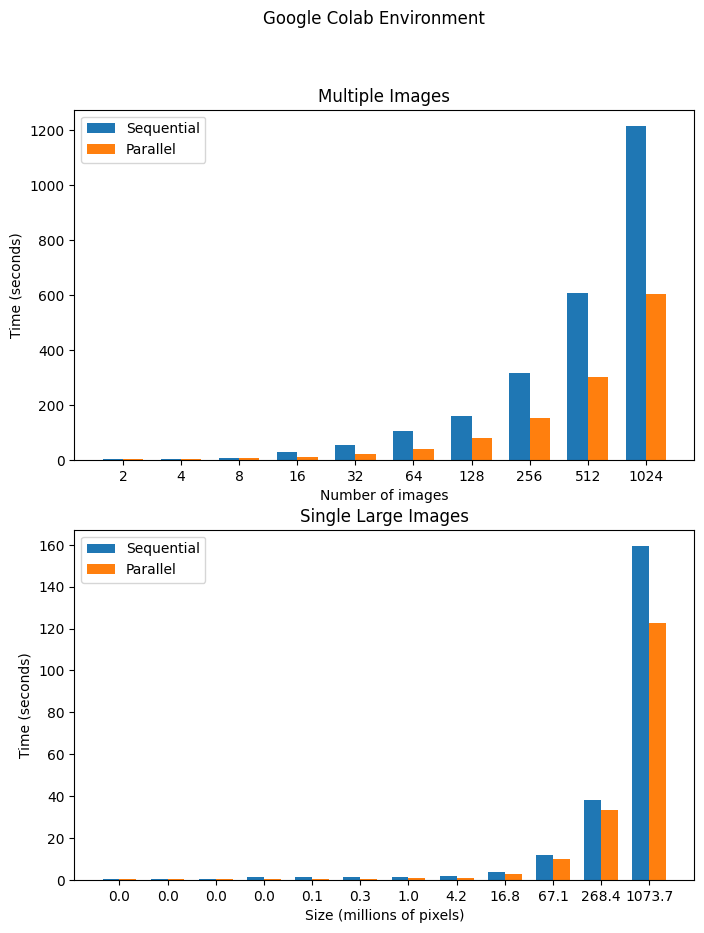

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# Create the bar graph with two subfigures
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Subfigure 1: Multiple images
width = 0.35
labels1 = [folder.split('_')[0] for folder in multiple_image_paths]
x1 = np.arange(len(labels1))

ax1.bar(x1 - width/2, mult_seq_timings, width, label='Sequential')
ax1.bar(x1 + width/2, mult_par_timings, width, label='Parallel')

ax1.set_ylabel('Time (seconds)')
ax1.set_xlabel('Number of images')
ax1.set_title('Multiple Images')
ax1.set_xticks(x1)
ax1.set_xticklabels(labels1)
ax1.legend()

# Subfigure 2: Single large images
labels2 = [str(round(size, 1)) for size, _ in sing_seq_timings]
sing_seq_time_labels = [time for _, time in sing_seq_timings]
sing_par_time_labels = [time for _, time in sing_par_timings]
x2 = np.arange(len(labels2))

bars_seq = ax2.bar(x2 - width/2, sing_seq_time_labels, width, label='Sequential')
bars_par = ax2.bar(x2 + width/2, sing_par_time_labels, width, label='Parallel')

ax2.set_ylabel('Time (seconds)')
ax2.set_xlabel('Size (millions of pixels)')
ax2.set_title('Single Large Images')
ax2.set_xticks(x2)
ax2.set_xticklabels(labels2)
ax2.legend()

# Add a title for the entire figure
fig.suptitle('Google Colab Environment')

# Save the figure to a file
plt.savefig('output_image.png', dpi=300, bbox_inches='tight')

# Optionally, display the plot
plt.show()

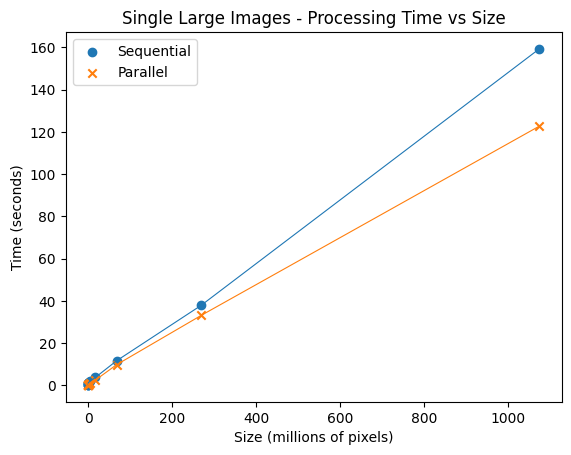

In [73]:
# Scatter plot of size vs time
size_seq = [size for size, _ in sing_seq_timings]
time_seq = [time for _, time in sing_seq_timings]

size_par = [size for size, _ in sing_par_timings]
time_par = [time for _, time in sing_par_timings]

# Sort the points by size
sorted_seq_points = sorted(zip(size_seq, time_seq))
sorted_par_points = sorted(zip(size_par, time_par))

# Unzip the sorted points
size_seq_sorted, time_seq_sorted = zip(*sorted_seq_points)
size_par_sorted, time_par_sorted = zip(*sorted_par_points)

fig, ax = plt.subplots()

ax.scatter(size_seq_sorted, time_seq_sorted, marker='o', label='Sequential')
ax.scatter(size_par_sorted, time_par_sorted, marker='x', label='Parallel')

# Connect the scatter points with lines
ax.plot(size_seq_sorted, time_seq_sorted, linestyle='-', linewidth=0.8)
ax.plot(size_par_sorted, time_par_sorted, linestyle='-', linewidth=0.8)

ax.set_ylabel('Time (seconds)')
ax.set_xlabel('Size (millions of pixels)')
ax.set_title('Single Large Images - Processing Time vs Size')
ax.legend()

plt.show()


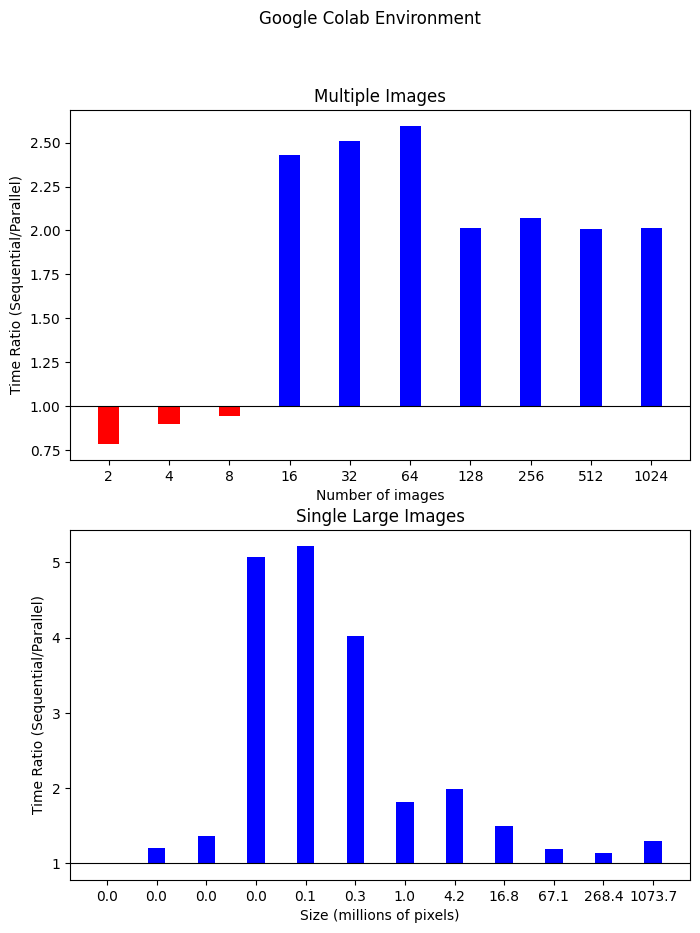

In [72]:
# Calculate the time ratios
mult_time_ratios = [seq/par for seq, par in zip(mult_seq_timings, mult_par_timings)]
sing_time_ratios = [seq/par for seq, par in zip(sing_seq_time_labels, sing_par_time_labels)]

# Create the bar graph with two subfigures
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Subfigure 1: Multiple images
width = 0.35
x1 = np.arange(len(labels1))

ax1.bar(x1, [max(0, ratio-1) for ratio in mult_time_ratios], width, bottom=1, color='blue')
ax1.bar(x1, [min(0, ratio-1) for ratio in mult_time_ratios], width, bottom=1, color='red')

ax1.set_ylabel('Time Ratio (Sequential/Parallel)')
ax1.set_xlabel('Number of images')
ax1.set_title('Multiple Images')
ax1.set_xticks(x1)
ax1.set_xticklabels(labels1)
ax1.axhline(1, color='black', linewidth=0.8)

# Subfigure 2: Single large images
x2 = np.arange(len(labels2))

ax2.bar(x2, [max(0, ratio-1) for ratio in sing_time_ratios], width, bottom=1, color='blue')
ax2.bar(x2, [min(0, ratio-1) for ratio in sing_time_ratios], width, bottom=1, color='red')

ax2.set_ylabel('Time Ratio (Sequential/Parallel)')
ax2.set_xlabel('Size (millions of pixels)')
ax2.set_title('Single Large Images')
ax2.set_xticks(x2)
ax2.set_xticklabels(labels2)
ax2.axhline(1, color='black', linewidth=0.8)

# Add a title for the entire figure
fig.suptitle('Google Colab Environment')

# Save the figure to a file
plt.savefig('output_ratio_image.png', dpi=300, bbox_inches='tight')

# Optionally, display the plot
plt.show()


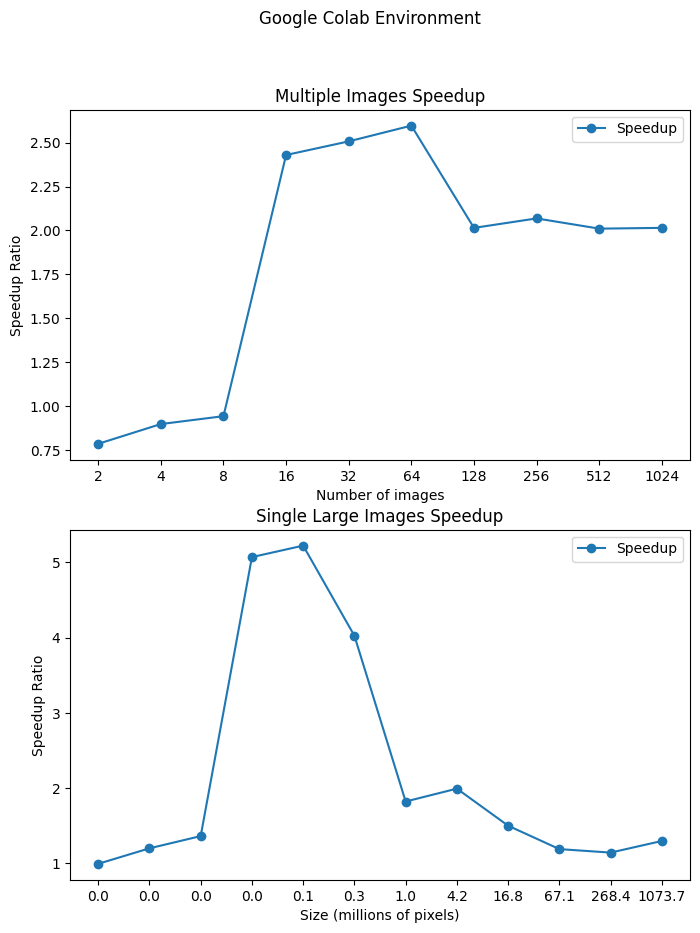

In [74]:
# Compute the speedup ratios
mult_speedup = np.array(mult_seq_timings) / np.array(mult_par_timings)
sing_speedup = np.array(sing_seq_time_labels) / np.array(sing_par_time_labels)

# Create the speedup ratio plot with two subfigures
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Subfigure 1: Multiple images
x1 = np.arange(len(labels1))

ax1.plot(x1, mult_speedup, marker='o', label='Speedup')

ax1.set_ylabel('Speedup Ratio')
ax1.set_xlabel('Number of images')
ax1.set_title('Multiple Images Speedup')
ax1.set_xticks(x1)
ax1.set_xticklabels(labels1)
ax1.legend()

# Subfigure 2: Single large images
x2 = np.arange(len(labels2))

ax2.plot(x2, sing_speedup, marker='o', label='Speedup')

ax2.set_ylabel('Speedup Ratio')
ax2.set_xlabel('Size (millions of pixels)')
ax2.set_title('Single Large Images Speedup')
ax2.set_xticks(x2)
ax2.set_xticklabels(labels2)
ax2.legend()

# Add a title for the entire figure
fig.suptitle('Google Colab Environment')

# Save the figure to a file
plt.savefig('speedup_plot.png', dpi=300, bbox_inches='tight')

# Optionally, display the plot
plt.show()
